# SPA1 parameter scan data analysis
Analyzing the data for SPA1 parameter scans

## Import packages

In [36]:
from itertools import product
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

import numpy as np
import pandas as pd
from scipy.interpolate import LinearNDInterpolator
from scipy.integrate import nquad, quad
from scipy.stats import norm
from tqdm import tqdm
tqdm.pandas()

# Set some constants
SAVE_DIR = Path('../../../results/SPA1 - parameter scans')

In [37]:
# plt.rcParams.values()

## Detuning, y-position and z-velocity
Analyzing a scan of detuning, y-position (i.e. perpendicular to molecular and microwave beam), and z-velocity.
### Load data

In [2]:
df = pd.read_csv(SAVE_DIR /  Path("det_pos_vel_3-31-2022.csv"))
df.drop(columns = 'Unnamed: 0', inplace = True)
df['vz'] = df.apply(lambda x: float(x.Vini[1:-1].lstrip().split()[2]), axis = 1)
df['y'] = df.apply(lambda x: float(x.Rini[1:-1].lstrip().split()[1]), axis = 1)

In [3]:
df

,power,detuning,muw_position,Rini,Vini,prob_ini,prob_fin,save_path,vz,y
0,0.0005,-10000000.0,[ 0. 0. -0.],[ 0. -0.004 -0.08 ],[ 0. 0. 150.],1.000000,1.472782e-07,NaN,150.0,-0.004
1,0.0005,-9500000.0,[ 0. 0. -0.],[ 0. -0.004 -0.08 ],[ 0. 0. 150.],1.000000,4.562644e-07,NaN,150.0,-0.004
2,0.0005,-9000000.0,[ 0. 0. -0.],[ 0. -0.004 -0.08 ],[ 0. 0. 150.],0.999999,7.568462e-07,NaN,150.0,-0.004
3,0.0005,-8500000.0,[ 0. 0. -0.],[ 0. -0.004 -0.08 ],[ 0. 0. 150.],0.999998,2.082471e-06,NaN,150.0,-0.004
4,0.0005,-8000000.0,[ 0. 0. -0.],[ 0. -0.004 -0.08 ],[ 0. 0. 150.],0.999998,2.093645e-06,NaN,150.0,-0.004
...,...,...,...,...,...,...,...,...,...,...
7744,0.0005,8000000.0,[ 0. 0. -0.],[ 0. 0.004 -0.08 ],[ 0. 0. 250.],1.000000,4.475547e-08,NaN,250.0,0.004
7745,0.0005,8500000.0,[ 0. 0. -0.],[ 0. 0.004 -0.08 ],[ 0. 0. 250.],1.000000,1.338654e-10,NaN,250.0,0.004
7746,0.0005,9000000.0,[ 0. 0. -0.],[ 0. 0.004 -0.08 ],[ 0. 0. 250.],1.000000,1.699925e-10,NaN,250.0,0.004
7747,0.0005,9500000.0,[ 0. 0. -0.],[ 0. 0.004 -0.08 ],[ 0. 0. 250.],1.000000,3.688515e-10,NaN,250.0,0.004


### Load kernel density estimates

In [5]:
with open('./kdes/y_dist_with_apertures.pickle', 'rb') as f:
    kde_y = pickle.load(f)
    
with open('./kdes/vz_dist_with_apertures.pickle', 'rb') as f:
    kde_vz = pickle.load(f)

### Weighted means instead of convoluting?
Might be faster and simpler to just use wighted means to calculate an approximation of the convolutions.

Calculate weights for each parameter combination:

In [6]:
df["weights"] = df.progress_apply(lambda x: kde_y(x.y)[0]*kde_vz(x.vz)[0], axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7749/7749 [00:20<00:00, 381.55it/s]


In [7]:
weight_sum = df.weights.sum()

In [17]:
sums = df.groupby('detuning').apply(lambda x: sum(x.prob_fin * x.weights))
weight_sums =  df.groupby('detuning').apply(lambda x: sum(x.weights))
weighted_means = (sums/weight_sums).to_frame('prob_fin').reset_index()

sums_ini = df.groupby('detuning').apply(lambda x: sum(x.prob_ini * x.weights))
weight_sums_ini =  df.groupby('detuning').apply(lambda x: sum(x.weights))
weighted_means_ini = (sums_ini/weight_sums_ini).to_frame('prob_ini').reset_index()

weighted_means = weighted_means.merge(weighted_means_ini, on = 'detuning')

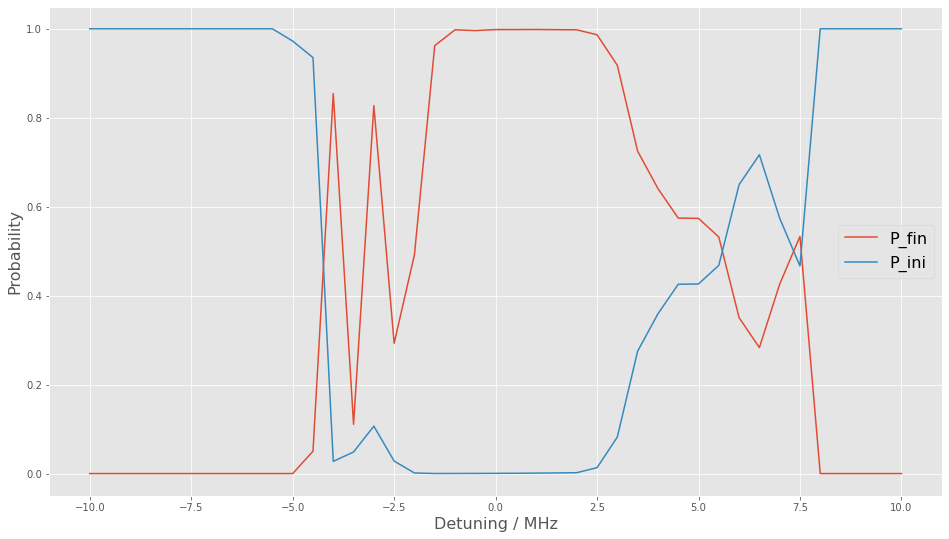

In [38]:
fig, ax = plt.subplots(figsize = (16,9))
ax.plot(weighted_means.detuning/1e6, weighted_means.prob_fin, label = 'P_fin')
ax.plot(weighted_means.detuning/1e6, weighted_means.prob_ini, label = 'P_ini')
ax.set_xlabel('Detuning / MHz')
ax.set_ylabel('Probability')
ax.legend()

### Compare to not using weighted means

<AxesSubplot:xlabel='detuning'>

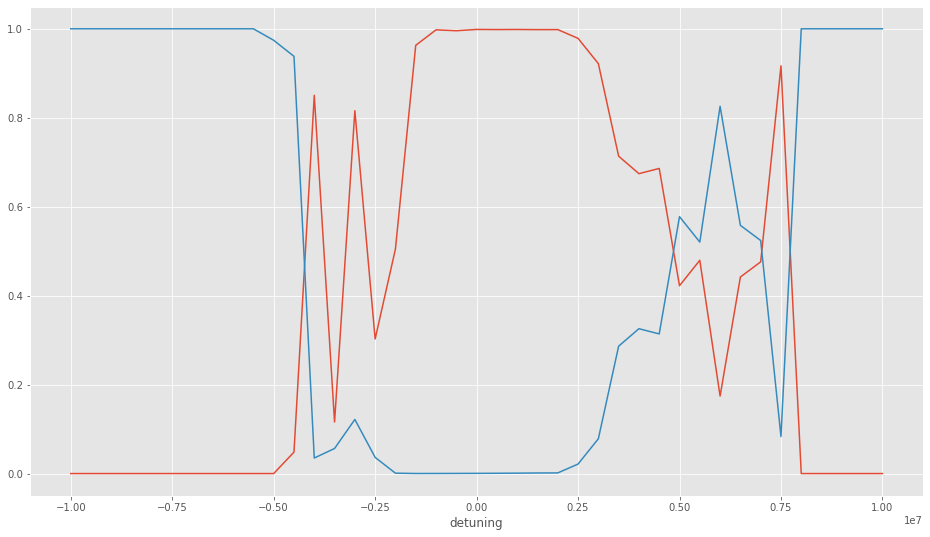

In [25]:
fig, ax = plt.subplots(figsize = (16,9))

index = df.apply(lambda x: (x.vz == 200) & (x.y == 0), axis = 1)
df[index].groupby('detuning').prob_fin.mean().plot(ax = ax)
df[index].groupby('detuning').prob_ini.mean().plot(ax = ax)

## ** The code below takes an unknown but very long time to run **
### Interpolation function for probabilities as function of velocity and position

In [216]:
def find_prob(detuning, y, vz):
    return df.query(f'(detuning=={detuning}) & (y=={y}) & (vz=={vz})').prob_fin.values[0]

points = (df.detuning.unique(), df.y.unique(), df.vz.unique())

points, values = zip(*[(point, find_prob(*point)) for point in tqdm(product(*points))])

prob_interp = LinearNDInterpolator(list(points), values, rescale = True)

0it [00:00, ?it/s]

AttributeError: 'DataFrame' object has no attribute 'prob'

In [39]:
prob_interp(0,0,200)

array(0.99857133)

In [185]:
kde_y(0.004)

array([0.4444034])

In [138]:
class GaussianDistr:
    def __init__(self, mu, sigma, lims = (180,220)):
        self._norm = norm
        self.sigma = sigma
        self.mu = mu
        self.lims = lims
        
        self.integral = self.calculate_integral()
    
    def pdf(self, x):
        if self.lims[0] < x < self.lims[1]:
            return self._norm.pdf(x, loc = self.mu, scale = self.sigma)/self.integral
        else:
            return 0
    
    def calculate_integral(self):
        return quad(lambda x: self._norm.pdf(x, loc = self.mu, scale = self.sigma), self.lims[0], self.lims[1])[0]

In [139]:
distr = GaussianDistr(184, 16)

In [140]:
distr.integral

0.5864818530278791

In [141]:
distr.pdf(184)

0.042514346175182134

### Convolve probabilities for each detuning with the y-position and z-velocity distributions

In [146]:
def convolve(prob_interp, detuning, distrs, ranges):
    """
    Convolves the probabilities in prob interp with distributions in distrs. 
    Ranges defines integration range for each distribution.
    """
    def func(*args):
        result = prob_interp(*args)
        for i in range(len(distrs)):
            result = result * distrs[i].pdf(args[i])
        return result
    return nquad(func, ranges, args = [detuning])

In [148]:
%%time
def prob_interp_ordered(vz, y, detuning):
    return prob_interp(detuning, y, vz)

distrs = [kde_y, GaussianDistr(200, 16)]
ranges = [(-0.03, 0.03),(180,220)]
convolve(prob_interp_ordered, 0,  distrs, ranges)

KeyboardInterrupt: 

In [68]:
probs = []
for detuning in df.detuning.unique():
    convolve(prob_interp_ordered, detuning,  distrs, ranges)

ValueError: non-broadcastable output operand with shape () doesn't match the broadcast shape (1,)